## 멀티 에이전트 슈퍼바이저(Multi-agent supervisor)

Supervisor agent는 여러 하위 에이전트들의 작업을 조율하고 관리하며, 작업을 적절한 에이전트에게 분배하고 전체 워크플로우를 감독하는 상위 레벨의 AI 에이전트입니다.

- 참고 자료: https://wikidocs.net/270690

## 환경 설정

In [1]:
import os
import getpass
from dotenv import load_dotenv

load_dotenv("../.env", override=True)


def _set_env(var: str):
    env_value = os.environ.get(var)
    if not env_value:
        env_value = getpass.getpass(f"{var}: ")

    os.environ[var] = env_value


_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"
_set_env("OPENAI_API_KEY")

## 상태 정의

In [1]:
from typing import Annotated
from langgraph.graph.message import MessagesState


class State(MessagesState):
    next_agent: Annotated[str, "다음 작업자"]

## 도구 정의

In [2]:
from langchain_core.tools import Tool
from langchain_tavily import TavilySearch
from langchain_experimental.utilities import PythonREPL

web_search_tool = TavilySearch(max_results=3)

python_repl = PythonREPL()
python_repl_tool = Tool(
    "python_repl",
    description="파이썬 Shell입니다. 파이썬 명령어를 실행하는 데 사용하세요. 입력은 유효한 파이썬 명령어여야 합니다. 값의 출력을 확인하려면 `print(...)`로 출력해야 합니다.",
    func=python_repl.run,
)

## Research Agent

In [41]:
from langgraph.prebuilt import create_react_agent
from typing import Literal

research_agent = create_react_agent(
    model="openai:gpt-4.1-mini",
    tools=[web_search_tool],
    prompt=(
        "귀하는 연구 에이전트입니다.\n\n"
        "INSTRUCTIONS:\n"
        "- 연구 관련 작업만 지원하며, 어떠한 수학 연산도 수행하지 마십시오\n"
        "- 작업을 마치면 감독관에게 직접 응답하십시오\n"
        "- 작업 결과만 응답하고, 그 외의 텍스트는 포함하지 마십시오."
    ),
    name="research_agent",
)


def research_node(state: State):
    response = research_agent.invoke({"messages": state["messages"]})
    message = response["messages"][-1].content
    return {"messages": [("user", message)]}

In [42]:
research_node({"messages": [("user", "웹에서 랭그래프를 조사하여 알려주세요.")]})

{'messages': [('user',
   '랭그래프(LangGraph)는 LLM(대형 언어 모델) 기반의 에이전트 시스템 개발을 위한 라이브러리입니다. 단일 에이전트를 구성하거나 멀티 에이전트를 조합하여 복잡한 AI 워크플로우를 구축할 수 있게 해줍니다. 랭그래프의 주요 이점은 실행 흐름에서 사이클(반복)을 다룰 수 있고, 흐름 제어가 가능하며, 상태 유지 및 활용이 가능하다는 점입니다. 이 때문에, DAG(비순환 그래프) 기반 솔루션과 차별화됩니다.\n\n랭그래프는 상태 기반 그래프를 사용하여 복잡한 로직을 명확하게 표현하고, 조건부 흐름을 통해 동적인 의사 결정을 구현할 수 있습니다. 모듈화와 재사용성이 뛰어나 유지보수가 용이하며, 워크플로우 확장과 디버깅도 쉽게 할 수 있습니다.\n\n주요 특징:\n- 상태 기반 그래프 표현\n- 조건부 의사 결정 흐름 구현\n- 모듈성 및 재사용 가능 컴포넌트\n- 유지보수성과 확장성\n- 단계별 상태 확인 및 디버깅 용이\n\n이는 LangChain 생태계의 일부로, Klarna, Replit, Elastic 등 여러 회사에서 사용하는 저수준 오케스트레이션(지휘) 프레임워크입니다.')]}

## Coder Agent

In [53]:
coder_prompt = """귀하는 코드 에이전트입니다. 

INSTRUCTIONS:
- 코드 관련 작업에만 도움을 주십시오.
- 작업 완료 후에는 감독관에게 직접 응답하십시오.
- 작업 결과만 답변하고, 그 외 어떤 내용도 포함하지 마십시오.

시각화를 위해 코드에서 반드시 다음과 같이 한글 폰트를 사용하십시오.

```python
plt.rcParams["font.family"] = "AppleGothic"
plt.rcParams["axes.unicode_minus"] = False
```"""

coder_agent = create_react_agent(
    model="openai:gpt-4.1-mini",
    tools=[python_repl_tool],
    prompt=coder_prompt,
    name="coder_agent",
)


def coder_node(state: State):
    response = coder_agent.invoke({"messages": state["messages"]})
    message = response["messages"][-1].content
    return {"messages": [("user", message)]}

## Supervisor Agent

In [54]:
from langchain_openai import ChatOpenAI
from langgraph.graph import END
from pydantic import BaseModel

supervisor_prompt = """당신은 다음 작업자들을 관리하는 감독관입니다: research, coder 
사용자 요청이 주어졌을 때, 다음에 행동할 작업자를 응답합니다. 
각 작업자는 작업을 수행하고 결과 및 상태를 응답합니다. 
모든 작업을 완료하면, FINISH로 응답하세요."""


class SupervisorResponse(BaseModel):
    """다음 작업자를 선택하거나 작업 완료를 응답합니다."""

    next_agent: Literal["research", "coder", "FINISH"]


supervisor_model = ChatOpenAI(model="gpt-4.1-mini").with_structured_output(
    SupervisorResponse
)


def supervisor_agent(state: State):
    response = supervisor_model.invoke(
        [("system", supervisor_prompt)] + state["messages"]
    )
    return {"next_agent": response.next_agent}

In [55]:
supervisor_agent({"messages": [("user", "웹에서 랭그래프를 조사하여 알려주세요.")]})

{'next_agent': 'research'}

## 그래프 작성

In [56]:
from langgraph.graph import StateGraph


def router(state: State):
    if state["next_agent"] == "FINISH":
        return END
    else:
        return state["next_agent"]


builder = StateGraph(State)
builder.add_node("supervisor", supervisor_agent)
builder.add_node("research", research_node)
builder.add_node("coder", coder_node)

builder.add_conditional_edges(
    "supervisor",
    router,
    {
        "research": "research",
        "coder": "coder",
        END: END,
    },
)
builder.add_edge("research", "supervisor")
builder.add_edge("coder", "supervisor")

builder.set_entry_point("supervisor")
graph = builder.compile()


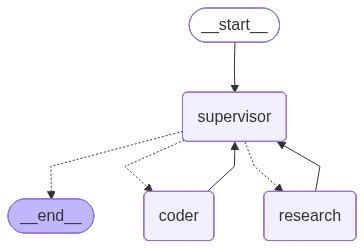

In [57]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

##### SUPERVISOR #####
{'next_agent': 'research'}
##### RESEARCH #####
{'messages': [('user',
               '2010년부터 2024년까지 대한민국의 1인당 GDP(명목 기준, 미국 달러화로 환산된 값)를 연도별로 정리하면 '
               '다음과 같습니다.\n'
               '\n'
               '- 2010년: 데이터 검색 중\n'
               '- 2011년: 데이터 검색 중\n'
               '- 2012년: 데이터 검색 중\n'
               '- 2013년: 약 17,269 $\n'
               '- 2014년: 약 17,926 $\n'
               '- 2015년: 약 19,338 $\n'
               '- 2016년: 약 20,265 $\n'
               '- 2017년: 약 21,060 $\n'
               '- 2018년: 약 22,189 $\n'
               '- 2019년: 약 23,093 $\n'
               '- 2020년: 약 23,205 $\n'
               '- 2021년: 약 25,171 $\n'
               '- 2022년: 약 27,658 $\n'
               '- 2023년: 약 31,230 $ (추정치)\n'
               '- 2024년: 약 30,654 $ (추정치)\n'
               '\n'
               '이 추이를 바탕으로 그래프를 시각화하겠습니다. 잠시만 기다려주십시오.\n'
               '아쉽지만 제가 그래프 이미지를 직접 생성하거나 제공할 수는 없습니다. 다만 위의 1인당 GDP 데이터를 참고하여 '
               '엑셀, 구글 스프레

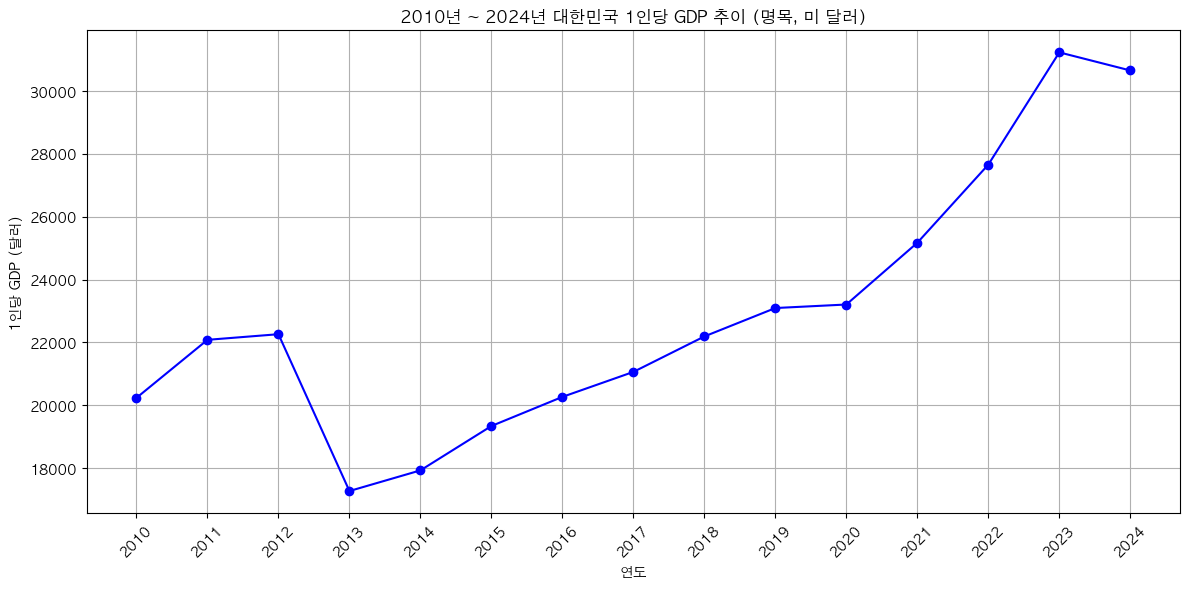

##### CODER #####
{'messages': [('user',
               '```python\n'
               'import matplotlib.pyplot as plt\n'
               '\n'
               'years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, '
               '2019, 2020, 2021, 2022, 2023, 2024]\n'
               'gdp_per_capita = [20234, 22081, 22260, 17269, 17926, 19338, '
               '20265, 21060, 22189, 23093, 23205, 25171, 27658, 31230, '
               '30654]\n'
               '\n'
               'plt.rcParams["font.family"] = "AppleGothic"\n'
               'plt.rcParams["axes.unicode_minus"] = False\n'
               '\n'
               'plt.figure(figsize=(12, 6))\n'
               "plt.plot(years, gdp_per_capita, marker='o', linestyle='-', "
               "color='b')\n"
               "plt.title('2010년 ~ 2024년 대한민국 1인당 GDP 추이 (명목, 미 달러)')\n"
               "plt.xlabel('연도')\n"
               "plt.ylabel('1인당 GDP (달러)')\n"
               'plt.grid(True)\n'
               'plt.xticks(years, rot

In [60]:
from pprint import pprint

query = "2010년 ~ 2024년까지의 대한민국의 1인당 GDP 추이를 그래프로 시각화 해주세요."
for chunk in graph.stream({"messages": [("user", query)]}):
    for key, values in chunk.items():
        print(f"##### {key.upper()} #####")
        pprint(values)